In [1]:
import warnings, itertools, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8, 5)


In [5]:
df = pd.read_excel("EastWestAirlines.xlsx", sheet_name="data")
df

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3994,4017,18476,0,1,1,1,8525,4,200,1,1403,1
3995,4018,64385,0,1,1,1,981,5,0,0,1395,1
3996,4019,73597,0,3,1,1,25447,8,0,0,1402,1
3997,4020,54899,0,1,1,1,500,1,500,1,1401,0


In [6]:
print("Shape :", df.shape)
display(df.head())


Shape : (3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [7]:
print("Missing values per column:\n", df.isna().sum())
df = df.dropna()

Missing values per column:
 ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


In [8]:
id_cols = [c for c in df.columns if "ID" in c.upper()]
df_num  = df.drop(columns=id_cols)


In [9]:
for col in df_num.columns:
    q_low, q_hi = df_num[col].quantile([0.01, 0.99])
    df_num[col] = df_num[col].clip(q_low, q_hi)


In [10]:
#eda plotting
scaler = StandardScaler()
X = scaler.fit_transform(df_num)
X_df = pd.DataFrame(X, columns=df_num.columns) 

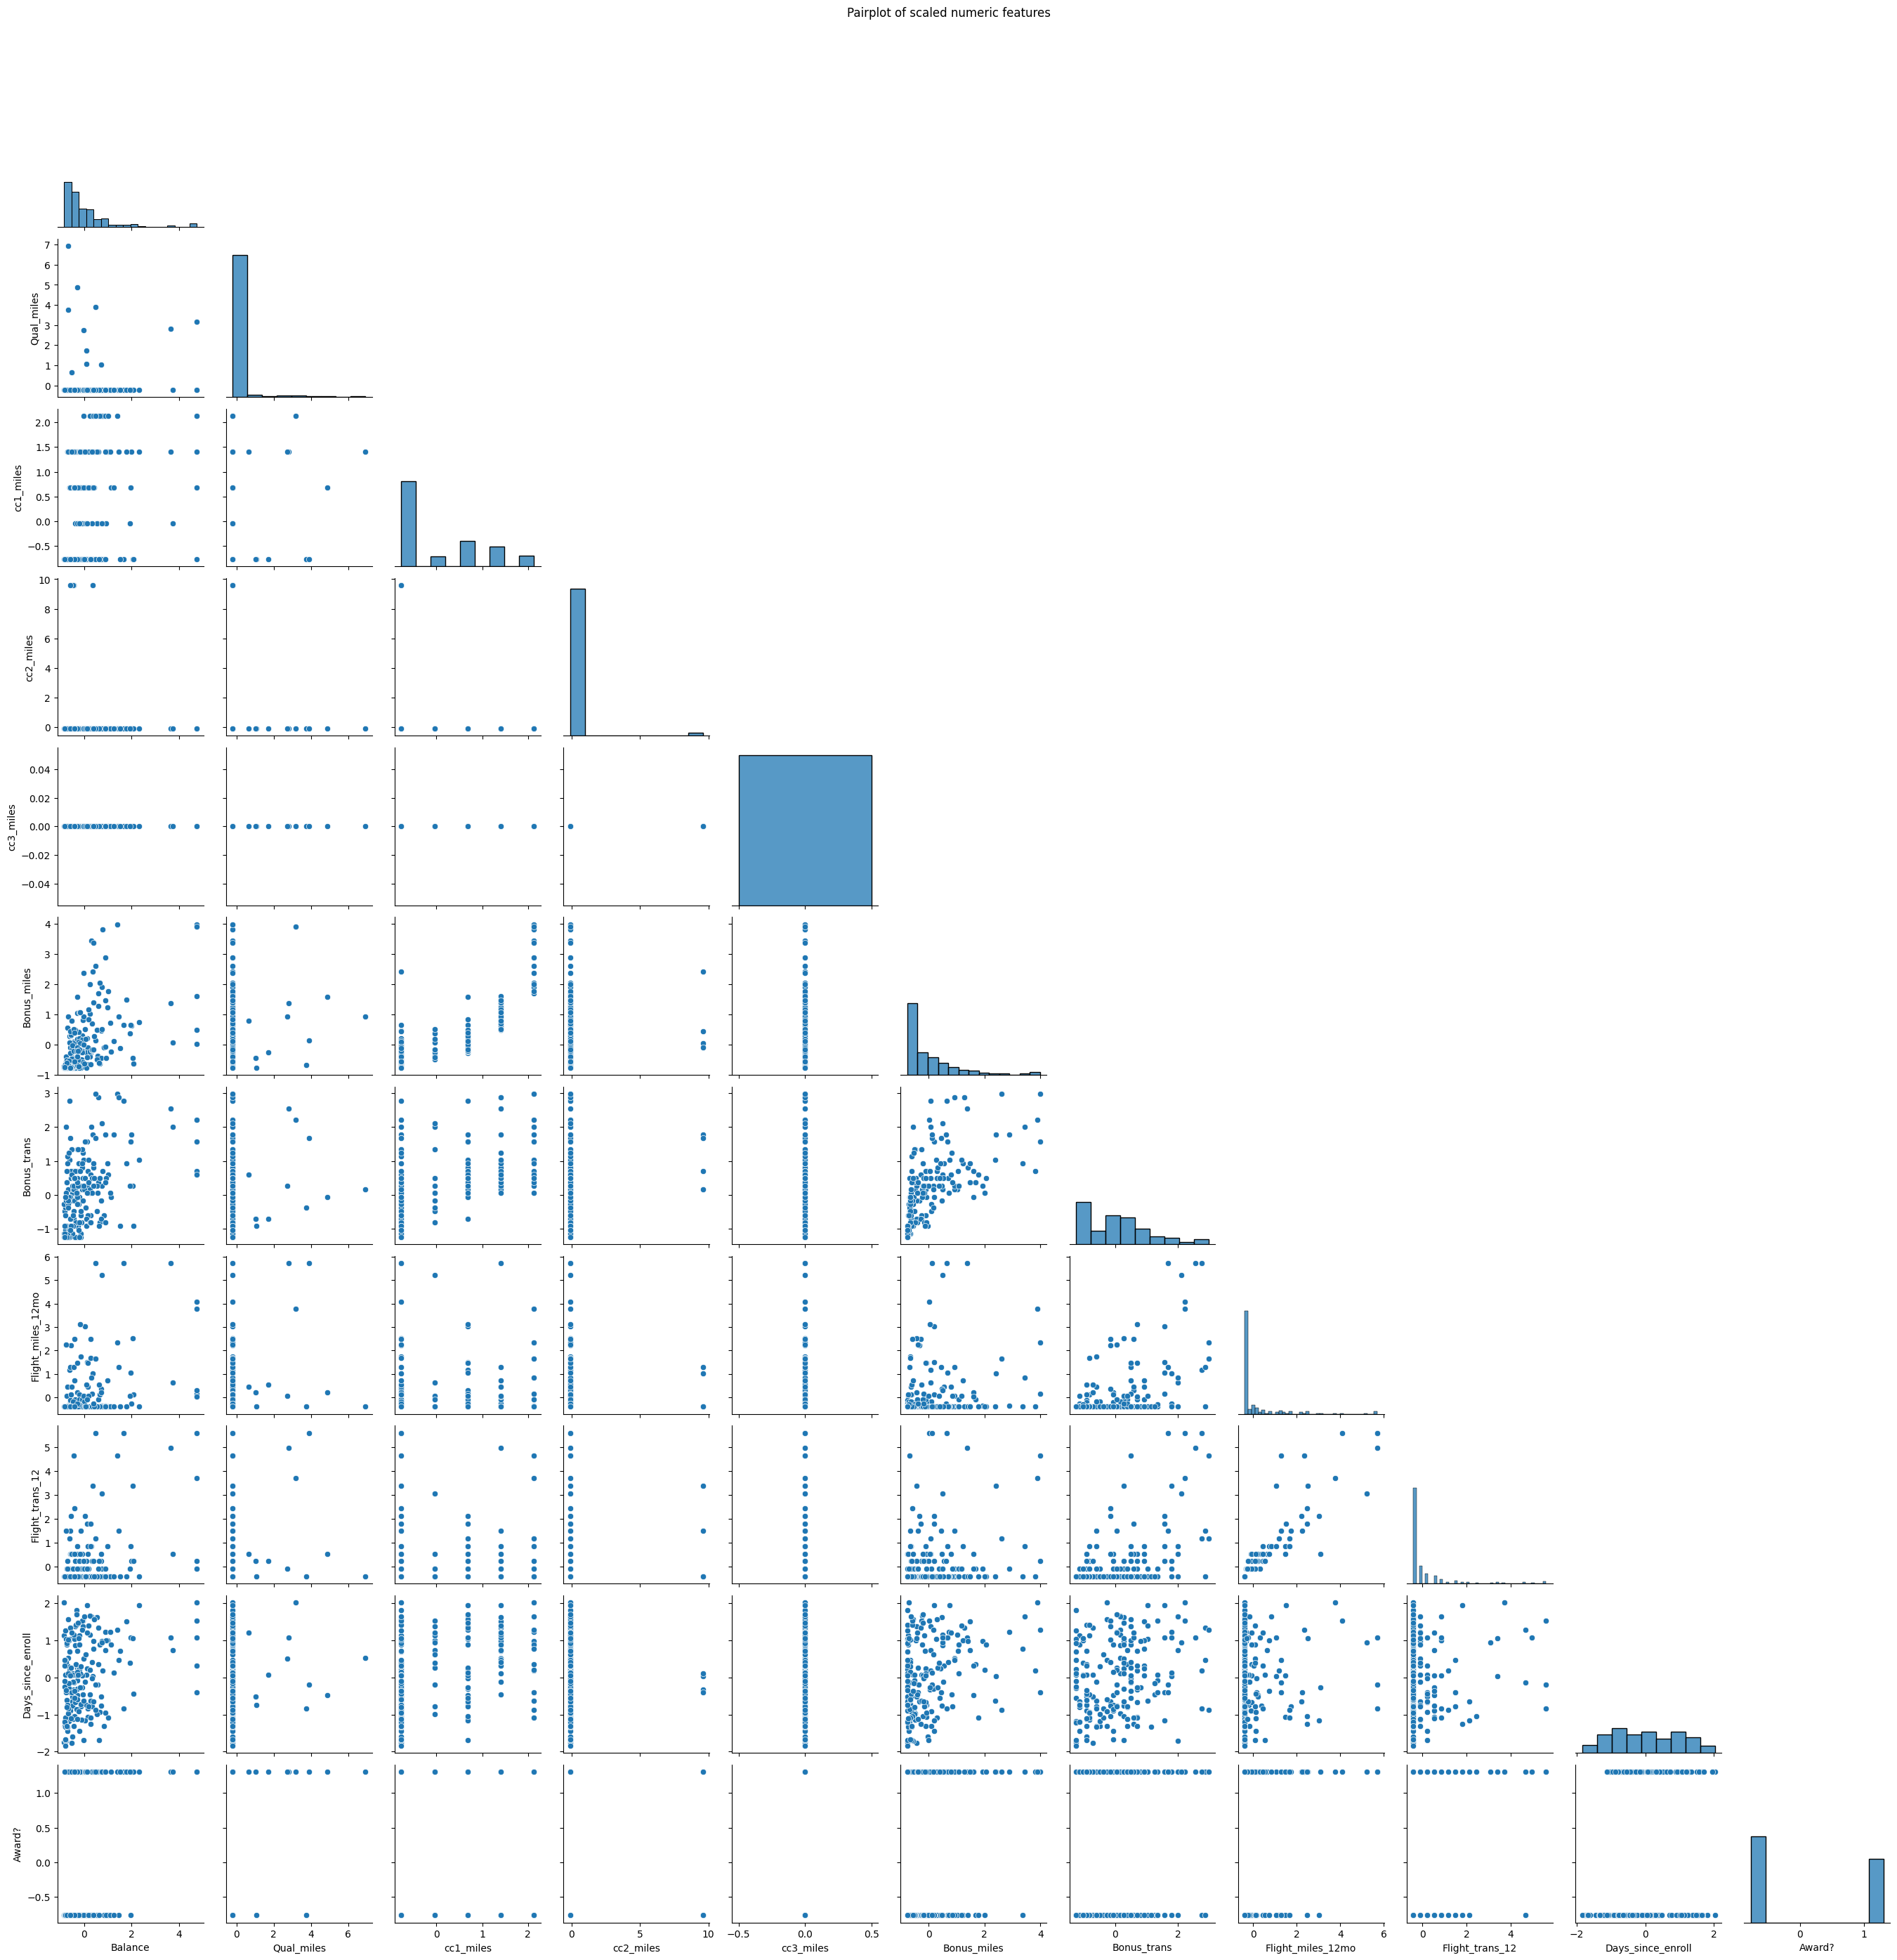

In [11]:
sns.pairplot(X_df.sample(min(200, len(X_df))), corner=True)
plt.suptitle("Pairplot of scaled numeric features", y=1.02)
plt.show()

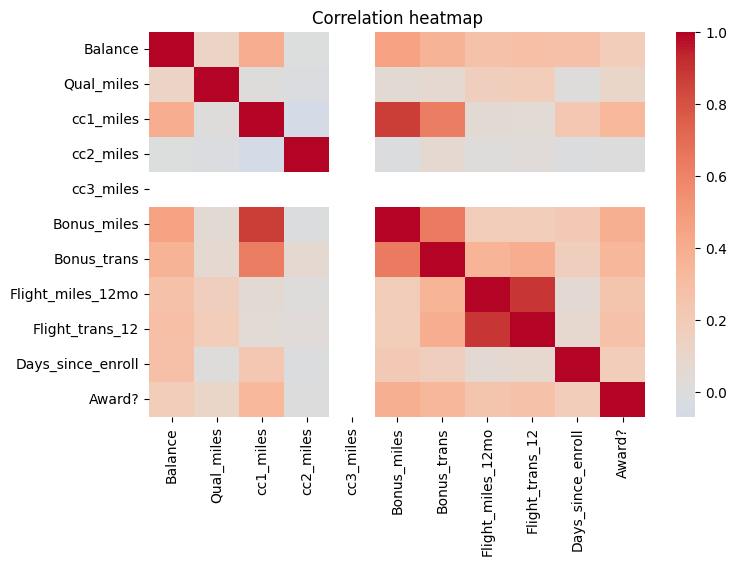

In [12]:
#correlation heatmap
sns.heatmap(pd.DataFrame(X, columns=df_num.columns).corr(),
            cmap="coolwarm", center=0, annot=False)
plt.title("Correlation heatmap")
plt.show()


In [13]:
#determining k
wcss, sil = [], []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(X, km.labels_))


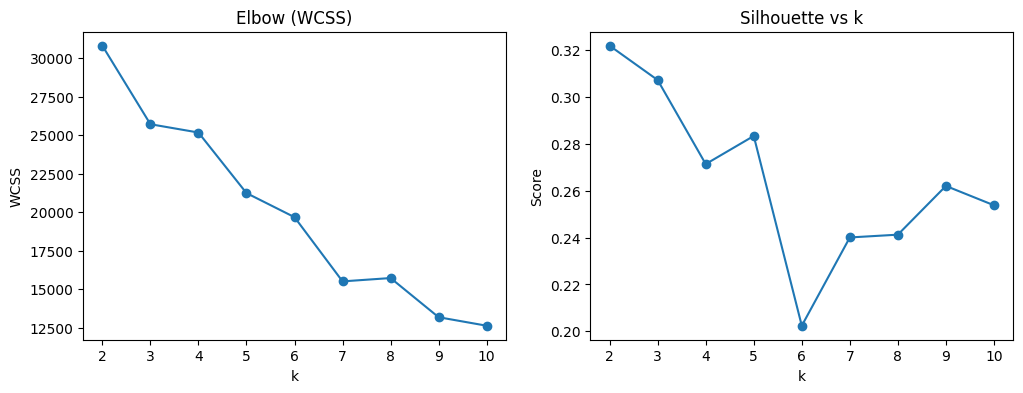

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(K_range, wcss, marker="o");  ax[0].set_title("Elbow (WCSS)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("WCSS")
ax[1].plot(K_range, sil, marker="o");   ax[1].set_title("Silhouette vs k")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Score")
plt.show()

In [15]:
best_k = K_range[np.argmax(sil)]
print(f"Chosen K (max silhouette): {best_k}")

Chosen K (max silhouette): 2


In [16]:
kmeans = KMeans(n_clusters=best_k, random_state=42).fit(X)
df["KMeans_cluster"] = kmeans.labels_


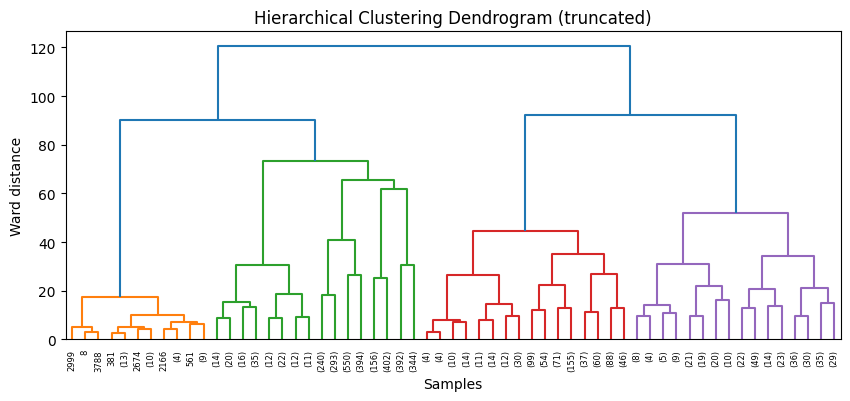

In [17]:
#hierarchical
link_mat = linkage(X, method="ward")
plt.figure(figsize=(10, 4))
dendrogram(link_mat, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Samples"); plt.ylabel("Ward distance")
plt.show()


In [18]:
n_clusters_h = best_k          # often similar to KMeans best_k
hclust = AgglomerativeClustering(n_clusters=n_clusters_h, linkage="ward")
df["Hier_cluster"] = hclust.fit_predict(X)

In [19]:
#DBSCAN
eps_vals       = np.linspace(1.0, 5.0, 9)   # tweak ranges as needed
min_samples_ls = [3, 4, 5, 6, 7]
best_db, best_score = None, -1

for eps, ms in itertools.product(eps_vals, min_samples_ls):
    db = DBSCAN(eps=eps, min_samples=ms).fit(X)
    labels = db.labels_
    if len(set(labels)) <= 1 or -1 in set(labels):   # ignore all‐noise / single cluster
        continue
    score = silhouette_score(X, labels)
    if score > best_score:
        best_score, best_db = score, db

if best_db:
    print(f"DBSCAN best eps={best_db.eps}, min_samples={best_db.min_samples}, silhouette={best_score:.3f}")
    df["DBSCAN_cluster"] = best_db.labels_
else:
    print("DBSCAN did not find a good clustering on this parameter grid.")
    df["DBSCAN_cluster"] = -1

DBSCAN best eps=5.0, min_samples=3, silhouette=0.649


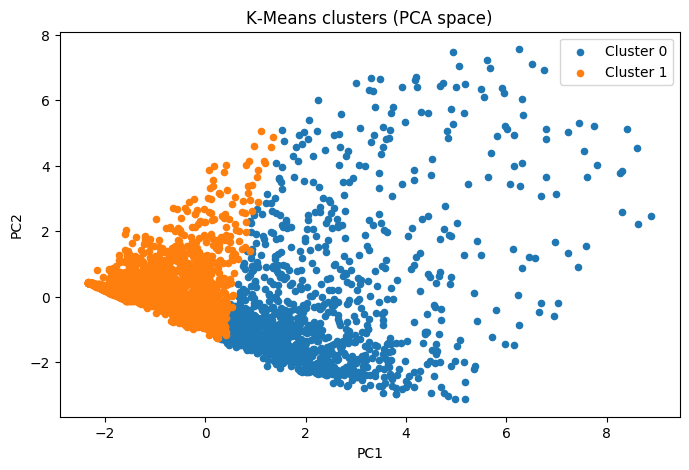

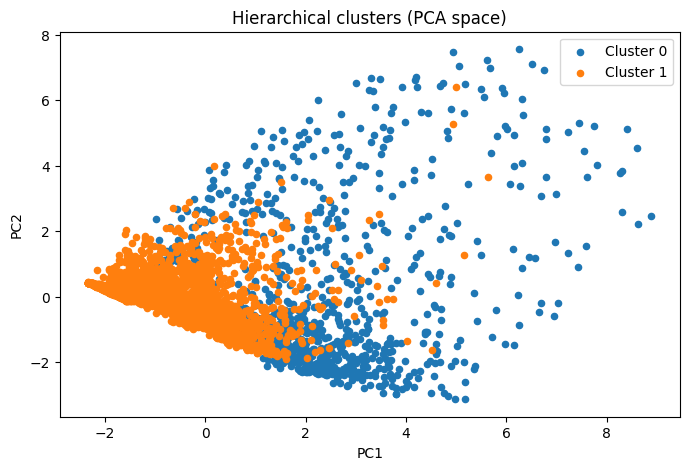

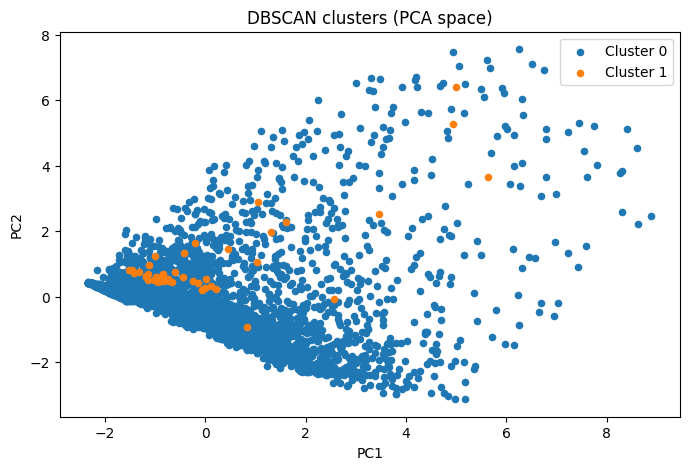

In [20]:
#PCA
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X)

def plot_clusters(labels, title):
    uniq = np.unique(labels)
    for u in uniq:
        mask = labels == u
        plt.scatter(XY[mask, 0], XY[mask, 1], label=f"Cluster {u}", s=20)
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend()

plt.figure(); plot_clusters(kmeans.labels_, "K‑Means clusters (PCA space)")
plt.figure(); plot_clusters(hclust.labels_, "Hierarchical clusters (PCA space)")
if (df["DBSCAN_cluster"] >= 0).any():
    plt.figure(); plot_clusters(best_db.labels_, "DBSCAN clusters (PCA space)")
plt.show()

In [21]:
#Scores summary
km_sil      = silhouette_score(X, kmeans.labels_)
hier_sil    = silhouette_score(X, hclust.labels_)
db_sil      = best_score if best_db else np.nan

summary = pd.DataFrame({
    "Method"       : ["KMeans", "Hierarchical", "DBSCAN"],
    "Silhouette"   : [km_sil, hier_sil, db_sil],
    "n_clusters"   : [best_k, n_clusters_h, len(set(best_db.labels_))- (1 if -1 in best_db.labels_ else 0) if best_db else np.nan]
})
print("\nSilhouette summary")
display(summary)



Silhouette summary


,Method,Silhouette,n_clusters
0,KMeans,0.321938,2
1,Hierarchical,0.304028,2
2,DBSCAN,0.648921,2


In [22]:
#interpretation
def cluster_profile(label_col):
    grp = df.groupby(label_col).mean(numeric_only=True)
    return grp.style.background_gradient(cmap="YlGnBu")

print("\nK‑Means cluster profile (scaled feature means):")
display(cluster_profile("KMeans_cluster"))


K‑Means cluster profile (scaled feature means):


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,Hier_cluster,DBSCAN_cluster
KMeans_cluster,,,,,,,,,,,,,,
0,1567.601669,135270.537936,270.630501,3.555387,1.009863,1.031108,40884.863429,20.235205,1022.576631,3.031108,4950.481032,0.698786,0.303490,0.006829
1,2234.675121,43284.274524,81.918314,1.324133,1.016785,1.002984,5474.073107,7.357702,183.516225,0.558747,3709.580380,0.208877,0.953376,0.012682
